In [3]:
import numpy as np
import numba
import pandas as pd
import scipy.special
import scipy.stats as st

# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition


import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

import bokeh


In [4]:
# Import the Iris dataset and convert it into a Pandas DataFrame
iris = sklearn.datasets.load_iris()

# Uncomment if you want to print the dataset description
# print(iris.DESCR)

# Make a DataFrame with a species column
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = iris.target_names[iris.target]

# Take a look at df_iris
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


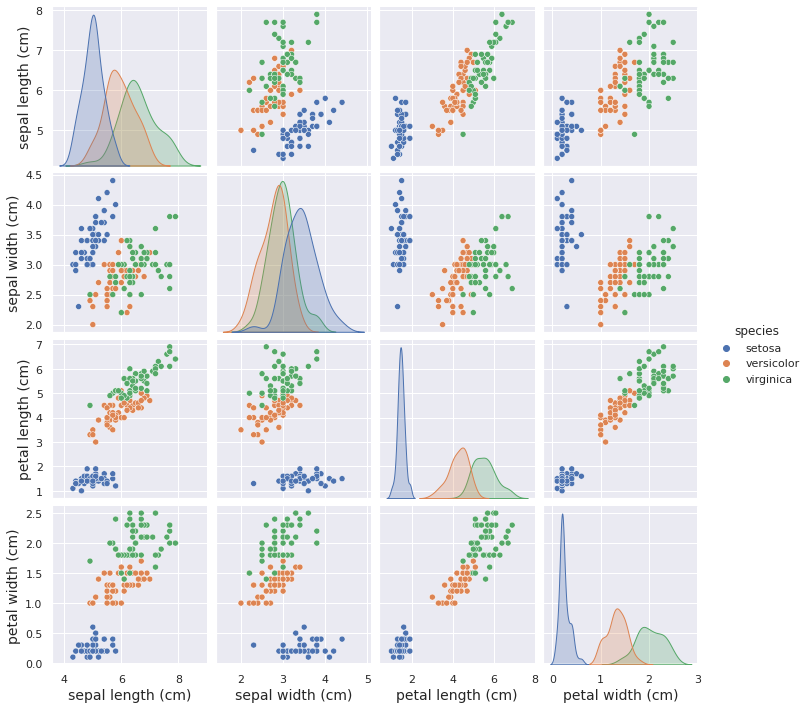

In [5]:
# Plot pairwise comparison to explore the data
_ = sns.pairplot(df_iris, hue='species')

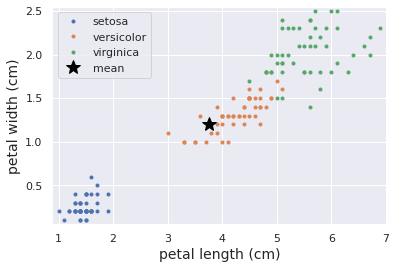

In [6]:
# Compute the mean
m = np.array([df_iris['petal length (cm)'].mean(), 
              df_iris['petal width (cm)'].mean()])

# Plot petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='.', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15,
         linestyle='none', label='mean')

plt.legend(loc=0)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)');

### Standardize the data

Because our plot labels have units, we know the two dimensions we're considering are both measured in centimeters, and so have similar scale. But they're different distances from zero!

In [7]:
# Substract the mean from the measurements.
df_centered = df_iris.loc[:, ['petal length (cm)', 'petal width (cm)']]
for col in df_centered.columns:
    df_centered[col] -= df_centered[col].mean()

# Take a look
df_centered.head()

,petal length (cm),petal width (cm)
0,-2.358,-0.999333
1,-2.358,-0.999333
2,-2.458,-0.999333
3,-2.258,-0.999333
4,-2.358,-0.999333


## Compute the covariance matrix 

In [8]:
cov_mat = np.cov(df_centered.transpose())
print('Covariance matrix \n', cov_mat)

Covariance matrix 
 [[3.11627785 1.2956094 ]
 [1.2956094  0.58100626]]


In [9]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors\n', eig_vecs)
print('\nEigenvalues\n', eig_vals)

Eigenvectors
 [[ 0.92177769 -0.38771882]
 [ 0.38771882  0.92177769]]

Eigenvalues
 [3.66123805 0.03604607]


# Now plotting the eigenvectors on top of our data to get a sense of how these principal components can capture the variation in the data.

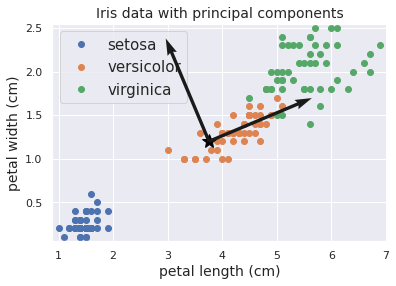

In [10]:
# Plot Petal length vs petal width only
for key, group in df_iris.groupby(['species']):
    plt.plot(group['petal length (cm)'], group['petal width (cm)'],
               label=key, marker='o', linestyle='none')

# Add the mean value to the plot
plt.plot(m[0], m[1], marker='*', color='black', markersize=15)

# Add arrows showing the eigenvectors
plt.quiver([m[0]]*2, [m[1]]*2, eig_vecs[:,1], eig_vecs[:,0], zorder=11, 
           width=0.01, scale=3)
    
# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.02)
plt.xlabel('petal length (cm)')
plt.ylabel('petal width (cm)')
plt.title('Iris data with principal components');

Select the  k  largest eigenvalues and their associated eigenvectors.

Compute how much variance is explained by each principal component

In [11]:
print("""
PCA 1: {0:.2f}% of the variance
PCA 2:  {1:.2f}% of the variance
""".format(*tuple(eig_vals / np.sum(eig_vals) * 100)))


PCA 1: 99.03% of the variance
PCA 2:  0.97% of the variance



Transform the data into a  k  dimensional subspace using those  k  eigenvectors.

In [12]:
# Project data to our 1D space
df_1D = pd.DataFrame(np.dot(df_iris.loc[:,['petal length (cm)',
                                           'petal width (cm)']], eig_vecs[:,0]),
                     columns=['projection'])

# Add back the species column
df_1D['species'] = df_iris['species']
df_1D.head()

,projection,species
0,1.368033,setosa
1,1.368033,setosa
2,1.275855,setosa
3,1.460210,setosa
4,1.368033,setosa


### Now we can plot our data in 1D only while maintaining ≈98% percent of the variability in the data!

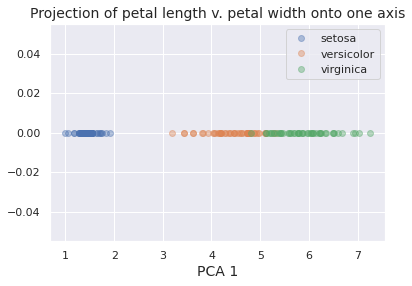

In [13]:
for key, group in df_1D.groupby(['species']):
    plt.plot(group['projection'], np.zeros_like(group['projection']), alpha=0.4, 
             label=key, marker='o', linestyle='none')

plt.margins(0.05)
plt.xlabel('PCA 1')
plt.legend(np.array(['setosa', 'versicolor','virginica']))
plt.title('Projection of petal length v. petal width onto one axis');

## We were able to project 2-D data onto a 1-D axis

In [14]:
# Instantiate the PCA object
sklearn_pca = sklearn.decomposition.PCA()

# Pass the data to the fit method
sklearn_pca.fit(df_iris[iris.feature_names])

# Print the variance explained
print('Variance percent explained\n', sklearn_pca.explained_variance_ratio_)

Variance percent explained
 [0.92461872 0.05306648 0.01710261 0.00521218]


In [15]:
# Perform the PCA again retaining only the top 2 components
sklearn_pca = sklearn.decomposition.PCA(n_components=2)
sklearn_pca.fit(df_iris[iris.feature_names])

# Project the data into this 2D space and convert it back to a tidy dataframe
df_2D = pd.DataFrame(sklearn_pca.transform(df_iris[iris.feature_names]),
                     columns=['PCA1', 'PCA2'])

# Create a column for species name
df_2D['species'] = df_iris['species']

# Look at the result
df_2D.head()

,PCA1,PCA2,species
0,-2.684126,0.319397,setosa
1,-2.714142,-0.177001,setosa
2,-2.888991,-0.144949,setosa
3,-2.745343,-0.318299,setosa
4,-2.728717,0.326755,setosa


plotting our original 4-D data onto a 2-D space that retains nearly 93% of the variability.

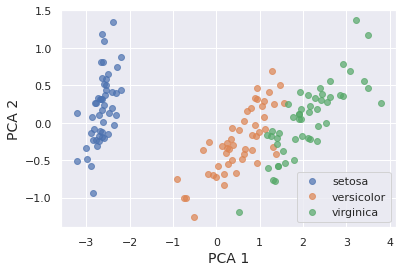

In [16]:
for key, group in df_2D.groupby(['species']):
    plt.plot(group.PCA1, group.PCA2, 'o', alpha=0.7, label=key)

# Tidy up plot
plt.legend(loc=0)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2');

Summary
So what have we learned by doing this analysis?

We can implement PCA in Python.
Methodologically, there are two ways to do it: approaches from linear algebra, or with scikit-learn.

Practically, PCA takes a  p  dimensional dataset as input and outputs two things that might interest us:

a transformed dataset in  k  dimensions and
a set of eigenvectors and associated eigenvectors that indicate the "percent variance" explained.
Here, the transformed dataset was our endpoint, since we were satisfied to think about high-dimensional differences as a 1 or 2-D distances. But can we learn something about data from the way we transformed it? Is it more than a visual heuristic? Is a plot my only reward for all this adventurous math?

PCA doesn't necessarily provide statistical information or a useful metric. But it will make your data easier to look at.
Even if, as in the case of the iris data, we had a single principal component that described most of the variation, it is not necessarily wise to use that as a mathematical or statistical model for the data. In fact, we may know beforehand that we do not expect to predict the data with purely linear relationships. What's more, as the weights of the principal components do not necessarily represent physical quantities, such models can be hard to verify with pre-existing data. See an internet rant about "Unprincipled Component Analysis" for more information.

Also note that PCA is not scale invariant; you can easily imagine that if we analyzed the same measurements, but in different units, the eigenvector weights would be very different! Moreover, a dimension varying from 0.1 to 0.2 might be considered much less significant than a dimension varying from 100 to 200. So any implementation of PCA includes a somewhat subjective choice of scale, though scale-invariant methods do exist.

To capture the confusion around the true usefulness of PCA in data analysis, Lior Pachter collected these quotations in his blog post on PCA (all emphasis ours):

"PCA is not a statistical method to infer parameters or test hypotheses. Instead, it provides a method to reduce a complex dataset to lower dimension to reveal sometimes hidden, simplified structure that often underlie it."
"PCA is a statistical method routinely used to analyze interrelationships among large numbers of objects."
PCA is "more useful as a visualization technique than as an analytical method."
PCA is a "mathematical algorithm that reduces the dimensionality of the data while retaining most of the variation in the data set."
However, as we might intuit, the eigenvalues and eigenvectors do contain some statistical information. Pachter talks about other approaches to using PCA, which are more interested in the new dimensions onto which the data is projected, rather than the projected data itself. For example, the new dimensions define an "affine subspace closest to a set of points." In 0-D, this is the centroid, or the single point closest to all the data points. In 1-D, when we collapse the data onto a single line, that line is the "average line" at a minimal orthogonal distance from all the data.